# Proyecto 6: Sistemas de recomendación

## Dataset

El dataset que vamos a usar en este proyecto es el del proyecto [MovieLens](http://grouplens.org/datasets/movielens/). Estos son relevados por el grupo de investigación GroupLens de la Universidad de Minnesota. Vamos a usar la versión 100K.

Está basado en un sistema de rating de 5 estrellas y texto libre para tags a partir del servicio de recomendaciones MovieLens. Contiene 100.000 ratings para 1.682 películas. Los datos fueron creados por 943 usuarios.

En el [Readme](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt) del dataset se puede encontrar información adicional. A continuación vamos a describir cada uno de ellos.

### Ratings (u.data)

Cada línea representa el rating para una película para un usuario. Los ratings están basados en un sistema de 5 estrellas, con una salto de 0.5 estrellas. Los timestamps están expresados en segundos desde la medianoche de 01/1970 (UTC). El formato es:

`user id | item id | rating | timestamp`

### Usuarios (u.users)

Cada línea del archivo representa un usuario. Se incluye información demográfica. El formato es:

`user id | age | gender | occupation | zip code`

### Películas (u.item)

Cada línea corresponde a una película. Puede haber inconsistencias en los nombres. El formato es:

`movie id | movie title | release date | video release date | IMDb URL | generos`



Las columnas con los generos son binarias indicando la presencia o ausencia de cada uno en la película. Los géneros pueden ser:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* unknown

## Experimentación

Durante todo este proyecto vamos a utilizar la librería `surprise` para llevar a cabo las experimentaciones.

Como se mencionó en clase, las implementaciones en esta librería tiene algunas mejoras respecto de las estrategias convencionales como SVD. Esto se traduce en una mayor cantidad de parámetros para optimizar.

Vamos a levantar los datos. En primer lugar, definamos el formato para poder leer los datos.

**1) Utilizar** el `Reader` con el parámetro `line_format` igual a `'user item rating timestamp'` y `sep` como `'\t'`. Guardarlo en una variable `reader`.

In [1]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple, defaultdict

Utilizando este `reader` cargar los datos:

In [2]:
reader=Reader(line_format='user item rating timestamp', sep="\t")

In [3]:
data = Dataset.load_from_file('./dataset/ml-100k/u.data', reader=reader)

__2) Ejecutar una corrida inicial usando cross validation y el algoritmo SVD (5 folds). Imprimir los RMSE de testing.__

In [4]:
algo = SVD()
cv = cross_validate(algo, data, measures=["RMSE"], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9362  0.9366  0.9308  0.9451  0.9314  0.9360  0.0051  
Fit time          13.36   13.21   13.25   13.18   13.44   13.29   0.10    
Test time         0.62    0.46    0.44    0.44    0.46    0.48    0.07    


__3) Evaluar el RMSE (promedio de cross validation) de testing de acuerdo a la cantidad de factores en SVD.__

In [5]:
rmse_test_means = []

factors = [5, 50, 100, 200]

for factor in factors:
    algo=SVD(n_factors=factor)
    cv=cross_validate(algo, data, measures=["RMSE"], cv=5, verbose=True)
    rmse_test_means.append(np.mean(cv["test_rmse"]))
rmse_test_means

[0.9379857265911185,
 0.9344786441490666,
 0.9346635321675366,
 0.9435700896269312]

El promedio de rmse se muestra levemente elevado con 5 factores y marcadamente elevado con 200, mientras que con 50 y 100 factores dicho promedio disminuye.

__4) Graficar los promedios RMSE del conjunto de testing de acuerdo a la cantidad de factores en SVD.__

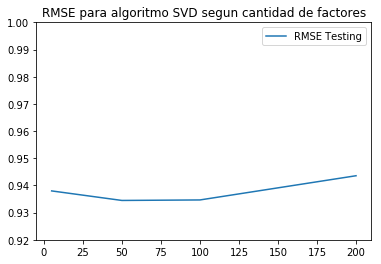

In [6]:
plt.plot(factors, rmse_test_means, label="RMSE Testing")
plt.ylim(0.92, 1)
plt.legend(loc="best")
plt.title("RMSE para algoritmo SVD segun cantidad de factores")
plt.show()

__5) Usando GridSearch, encontrar el mejor estimador usando SVD con 500 factores. Imprimir el mejor rmse. Utilizar `refit` para obtener obtener el mejor estimador ya ajustado como resultado.__

Utilizar el espacio de parámetros:
* n_epochs: [5, 10]
* lr_all: [0.002, 0.005]
* reg_all: [0.4, 0.6]


In [7]:
param_grid = {"n_factors": [500], "n_epochs": [5, 10], 
              'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, refit=True, n_jobs=-1)

gs.fit(data)

In [8]:
print(gs.best_params['rmse'])

{'n_factors': 500, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [9]:
print(gs.best_score['rmse'])

0.9623969670564986


__6) Obtener una predicción para el usuario 321 para la película Titanic.__

In [10]:
#Funcion para crear un diccionario de las peliculas con su id y nombre. 
#que luego servira de input para la funcion que dara el iid de las peliculas
def movie_name():
    lookup = defaultdict()
    for line in open('./dataset/ml-100k/u.item'):
        record = line.strip().split('|')
        movie_id, movie_name = record[0], record[1]
        lookup[movie_id] = movie_name  
    return lookup

In [11]:
#Funcion que toma como input un diccionario, en este caso el que contiene las peliculas, y el valor a ser hayado(Titanic)
#Y devuelve el iid de la pelicula
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

In [12]:
#Ingreso el diccionario de peliculas y la pelicula de la cual se realizara la prediccion.
getKeysByValue(movie_name(), "Titanic (1997)")

['313']

In [14]:
uid = str(321) #user id, el numero se pone en string porque predict toma el raw user id 
idd = str(313) #movie id
predictions_321 = gs.predict(uid, idd)#realizo la prediccion para el usuario y la pelicula dada
print(predictions_321)

user: 321        item: 313        r_ui = None   est = 3.98   {'was_impossible': False}


__7) Desarrollar una función que dado un usuario, obtenga la mejor predicción disponible (de acuerdo a nuestros datos de películas).__

In [15]:
test_set = data.construct_testset(raw_testset=data.raw_ratings)
predictions = gs.test(test_set)

In [16]:
#la funcion devuelve las mejores N predicciones de un diccionario de predicciones
#En este caso, usamos n=1 para obtener la mejor

def best_prediction(uid_n, predictions, n=1):
    # la funcion toma como input el user id, dicccionario de predicciones y el N de mejores predicciones
    
    #creo un diccionario donde se incorporaran las mejores predicciones con su item id y prediccion estimadas
    top_n = defaultdict(list)    
    
    #itero para mapear cada id de usuario con el item y la prediccion. Luego lo agrego al al dicc top_n
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    #Luego se ordena las predicciones para cada usuario y se recupera la N mas alta
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    #Devuelve un diccionario con el user id como key y los valores en una tupla
    return top_n[uid_n]

In [17]:
best_prediction("111", predictions)

[('272', 3.987726706483361)]